# Franz Albert Rivas Rios

In [3]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime

In [4]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from keras.models import Sequential

In [5]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [6]:
#
# Lectura de los datos
#
#dataset = pd.read_csv('Futuros del Índice S&P 500 - Este es el bueno.csv', index_col='Fecha', parse_dates=['Fecha'])
#dataset.head()
# start = datetime.datetime(2010,1,1)
# end = datetime.datetime(2020,12,31)
dataset = web.get_data_yahoo('VOO','01/01/2010',interval='m')
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-10-01,109.279999,103.500000,105.080002,108.300003,951600.0,88.645699
2010-11-01,112.300003,107.480003,108.919998,108.180000,1070400.0,88.547455
2010-12-01,115.599998,109.879997,109.919998,115.139999,1670300.0,94.244339
2011-01-01,119.220001,115.480003,115.940002,117.699997,4402150.0,96.780792
2011-02-01,123.220001,118.379997,118.480003,121.779999,2761400.0,100.135674


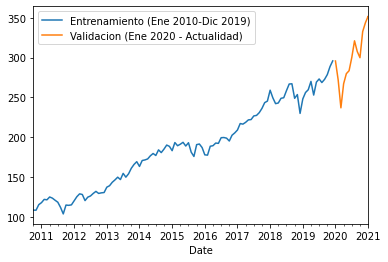

In [7]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#

set_entrenamiento = dataset['2010':'2019'].iloc[:,3:4]
set_validacion = dataset['2020':].iloc[:,3:4]
set_entrenamiento['Close'].plot(legend=True)
set_validacion['Close'].plot(legend=True)
plt.legend(['Entrenamiento (Ene 2010-Dic 2019)', 'Validacion (Ene 2020 - Actualidad)'])
plt.show()

In [8]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
print(sc)
print(set_entrenamiento)
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
print(set_entrenamiento_escalado)

MinMaxScaler()
                 Close
Date                  
2010-10-01  108.300003
2010-11-01  108.180000
2010-12-01  115.139999
2011-01-01  117.699997
2011-02-01  121.779999
...                ...
2019-08-01  268.600006
2019-09-01  272.600006
2019-10-01  278.549988
2019-11-01  288.649994
2019-12-01  295.799988

[111 rows x 1 columns]
[[0.02485961]
 [0.02423551]
 [0.06043272]
 [0.07374662]
 [0.09496569]
 [0.09215728]
 [0.11067198]
 [0.10307885]
 [0.08924487]
 [0.076347  ]
 [0.04243813]
 [0.        ]
 [0.05783234]
 [0.05606411]
 [0.05918455]
 [0.0859164 ]
 [0.11264825]
 [0.13116294]
 [0.12689829]
 [0.08695653]
 [0.10942377]
 [0.11722489]
 [0.13365928]
 [0.14728521]
 [0.13386727]
 [0.13771585]
 [0.13969216]
 [0.17474516]
 [0.18421056]
 [0.2067818 ]
 [0.22238404]
 [0.24006656]
 [0.22446431]
 [0.26492621]
 [0.2401706 ]
 [0.26253383]
 [0.29831501]
 [0.32338258]
 [0.34132515]
 [0.31027667]
 [0.34902232]
 [0.35276686]
 [0.35921574]
 [0.37981074]
 [0.39478885]
 [0.38194307]
 [0.41850433]
 [0.

## La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 726
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

In [9]:
time_step = 1
X_train = [] 
Y_train = [] 
m = len(set_entrenamiento_escalado)

In [10]:
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
len(X_train)

110

In [11]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
print(dim_entrada)
na = 200

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=12)

(1, 1)
Epoch 1/20
10/10 [==============================] - 2s 5ms/step - loss: 0.2266
Epoch 2/20
10/10 [==============================] - 0s 3ms/step - loss: 0.1116
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 0.0711
Epoch 4/20
10/10 [==============================] - 0s 3ms/step - loss: 0.0470
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 0.0299
Epoch 6/20
10/10 [==============================] - 0s 5ms/step - loss: 0.0227
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 0.0220
Epoch 8/20
10/10 [==============================] - 0s 4ms/step - loss: 0.0184
Epoch 9/20
10/10 [==============================] - 0s 4ms/step - loss: 0.0139
Epoch 10/20
10/10 [==============================] - 0s 4ms/step - loss: 0.0108
Epoch 11/20
10/10 [==============================] - 0s 4ms/step - loss: 0.0072
Epoch 12/20
10/10 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 13/20
10/10 [=======================

                 Close
Date                  
2020-01-01  295.690002
2020-02-01  271.739990
2020-03-01  236.820007
2020-04-01  267.100006
2020-05-01  279.750000
2020-06-01  283.429993
2020-07-01  300.100006
2020-08-01  321.019989
2020-09-01  307.649994
2020-10-01  299.820007
2020-11-01  332.640015
2020-12-01  343.690002
2021-01-01  351.899994
2021-01-25  351.739990
[[295.77048]
 [270.3667 ]
 [234.15448]
 [265.49753]
 [278.81284]
 [282.7102 ]
 [300.4966 ]
 [323.11508]
 [308.62204]
 [300.19614]
 [335.81683]
 [347.9843 ]
 [357.07938]]


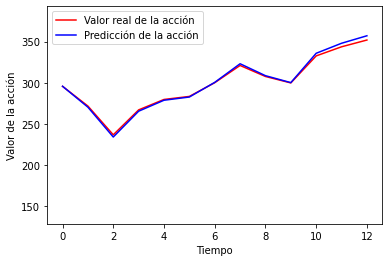

In [12]:
#
# Validación (predicción del valor de las acciones)
#

x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []

m = len(x_test)
for i in range(time_step,m):
  X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
print(set_validacion)
print(prediccion)
graficar_predicciones(set_validacion.values,prediccion)

In [13]:
score = modelo.evaluate(X_test, prediccion, batch_size=12, verbose=0)
print(' Train accuracy:', score)

 Train accuracy: 90529.5390625


# Ejericico

In [22]:
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2020,12,31)
facebook = web.DataReader('FB', 'yahoo', start, end)
dataset = facebook

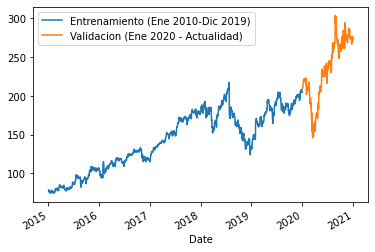

In [23]:
set_entrenamiento = dataset['2010':'2019'].iloc[:,3:4]
set_validacion = dataset['2020':].iloc[:,3:4]
set_entrenamiento['Close'].plot(legend=True)
set_validacion['Close'].plot(legend=True)
plt.legend(['Entrenamiento (Ene 2010-Dic 2019)', 'Validacion (Ene 2020 - Actualidad)'])
plt.show()

In [24]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
print(sc)
print(set_entrenamiento)
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)
print(set_entrenamiento_escalado)

MinMaxScaler()
                 Close
Date                  
2015-01-02   78.449997
2015-01-05   77.190002
2015-01-06   76.150002
2015-01-07   76.150002
2015-01-08   78.180000
...                ...
2019-12-24  205.119995
2019-12-26  207.789993
2019-12-27  208.100006
2019-12-30  204.410004
2019-12-31  205.250000

[1258 rows x 1 columns]
[[0.03067267]
 [0.02188916]
 [0.01463924]
 ...
 [0.93447198]
 [0.90874872]
 [0.91460439]]


In [25]:
time_step = 1
X_train = [] 
Y_train = [] 
m = len(set_entrenamiento_escalado)

In [26]:
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
len(X_train)

1257

In [27]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
print(dim_entrada)
na = 200

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=12)

(1, 1)
Epoch 1/20
105/105 [==============================] - 2s 3ms/step - loss: 0.1221
Epoch 2/20
105/105 [==============================] - 0s 3ms/step - loss: 0.0031
Epoch 3/20
105/105 [==============================] - 0s 3ms/step - loss: 4.9347e-04
Epoch 4/20
105/105 [==============================] - 0s 3ms/step - loss: 4.2847e-04
Epoch 5/20
105/105 [==============================] - 0s 3ms/step - loss: 4.2590e-04
Epoch 6/20
105/105 [==============================] - 1s 6ms/step - loss: 7.0727e-04
Epoch 7/20
105/105 [==============================] - 0s 3ms/step - loss: 4.1385e-04
Epoch 8/20
105/105 [==============================] - 0s 3ms/step - loss: 3.7756e-04
Epoch 9/20
105/105 [==============================] - 0s 3ms/step - loss: 3.9502e-04
Epoch 10/20
105/105 [==============================] - 0s 3ms/step - loss: 4.3392e-04
Epoch 11/20
105/105 [==============================] - 0s 3ms/step - loss: 4.0535e-04
Epoch 12/20
105/105 [==============================] - 0s 3ms/st

                 Close
Date                  
2020-01-02  209.779999
2020-01-03  208.669998
2020-01-06  212.600006
2020-01-07  213.059998
2020-01-08  215.220001
...                ...
2020-12-24  267.399994
2020-12-28  277.000000
2020-12-29  276.779999
2020-12-30  271.869995
2020-12-31  273.160004

[253 rows x 1 columns]
[[211.68962]
 [210.56552]
 [214.54543]
 [215.01126]
 [217.19862]
 [220.31755]
 [220.0745 ]
 [223.97282]
 [221.08711]
 [223.20334]
 [223.8311 ]
 [224.2057 ]
 [223.49698]
 [223.37547]
 [221.7959 ]
 [219.953  ]
 [216.84418]
 [219.80112]
 [225.30928]
 [211.43643]
 [203.71988]
 [206.0287 ]
 [211.74026]
 [212.02382]
 [212.77322]
 [214.272  ]
 [215.01126]
 [209.06674]
 [212.68205]
 [215.09227]
 [216.14545]
 [219.81123]
 [219.49733]
 [216.55054]
 [212.09468]
 [202.5149 ]
 [198.51538]
 [198.95073]
 [191.40886]
 [194.16212]
 [198.18127]
 [187.50238]
 [193.44339]
 [186.77383]
 [182.646  ]
 [170.92796]
 [179.71278]
 [171.67574]
 [155.75504]
 [171.71616]
 [147.22934]
 [150.66438]
 

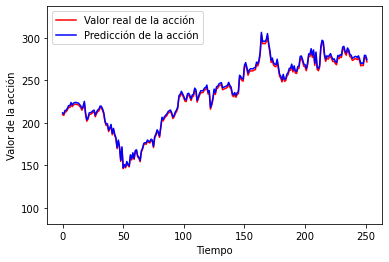

In [28]:
#
# Validación (predicción del valor de las acciones)
#

x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []

m = len(x_test)
for i in range(time_step,m):
  X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
print(set_validacion)
print(prediccion)
graficar_predicciones(set_validacion.values,prediccion)

In [29]:
score = modelo.evaluate(X_test, prediccion, batch_size=12, verbose=0)
print(' Train accuracy:', score)

 Train accuracy: 56925.9296875
